In [379]:
import numpy as np
import random, os
import importlib
from tqdm import tqdm as tqdm

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.distributions import gamma

import minebed.methods
import minebed.networks as mn
import minebed.static.bed as bed

In [298]:
# For Plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams.update({'font.size': 16})

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
import matplotlib.gridspec as gridspec

In [299]:
# set up the torch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [300]:
def seed_torch(seed=2019):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [301]:
seed_torch(1234567)

In [302]:
importlib.reload(bed)

<module 'minebed.static.bed' from '/Users/steven/phd/repos/minebed/src/minebed/static/bed.py'>

# Define Simulator: Linear Model

We wish to find optimal experimental designs for the following linear model with Gaussian and Gamma noise:

$$\mathbf{y} = \theta_0 \mathbf{1} + \theta_1 \mathbf{d} + \boldsymbol{\epsilon} + \boldsymbol{\nu}$$

The scientific aim is to estimate the offset $\theta_0$ and the slope $\theta_1$ using real-world observations.

In [303]:
def sim_linear_torch(d, prior, device):

    # sample random normal noise
    n_n = torch.empty(
        (len(d), len(prior)),
        device=device,
        dtype=torch.float).normal_(mean=0, std=1)

    # sample random gamma noise
    n_g = gamma.Gamma(
        torch.tensor([2.0], device=device),
        torch.tensor([2.0], device=device)).sample(
            sample_shape=(len(d), len(prior))).reshape(len(d), len(prior))

    # perform forward pass
    y = (prior[:, 0] + torch.mul(prior[:, 1], d) + n_n + n_g).T
    ygrads = prior[:, 1].reshape(-1, 1)

    return y, ygrads

The above function takes as input experimental designs and prior samples, and returns simulated data y and gradients of y with respect to designs. We'll need the latter ones later in order to compute gradients of the loss function.

See examples/bed_sgd_example.py to see how the exact training happens!

# Analyse Results

## Plot Training Curves

In [324]:
def ma(a, ws=100):
    return [np.mean(a[i:i + ws]) for i in range(0, len(a) - ws)]

In [325]:
data = torch.load('./linear_sgd_test.pt')

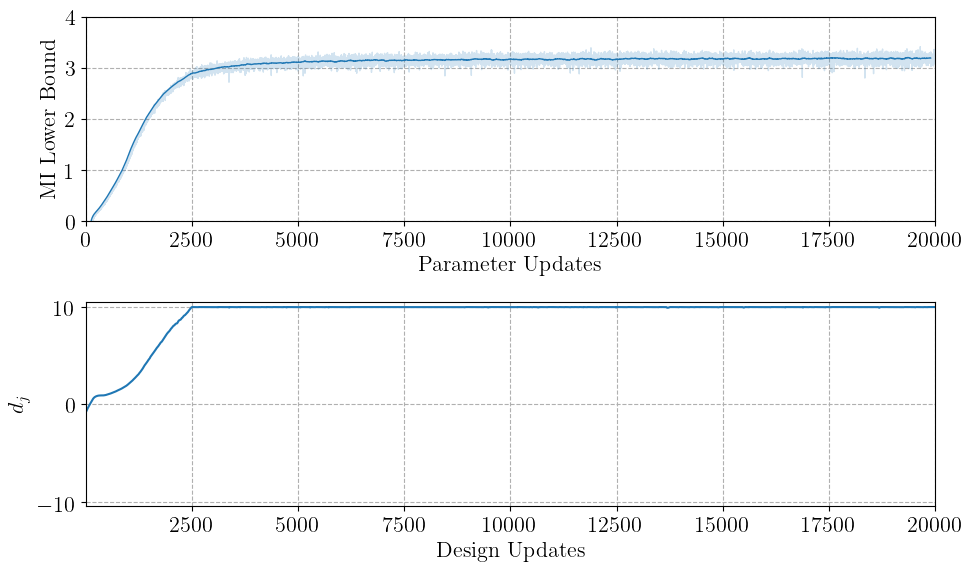

In [326]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(211)

loss = data['mi']
ax.plot(range(1, len(loss)+1), loss, lw=1, alpha=0.2, c=cycle[0])
mal = ma(loss, ws=100)
ax.plot(range(1, len(mal)+1), mal, lw=1, alpha=1, c=cycle[0])

ax.set_ylim([0, 4])
ax.set_xlim([0, len(loss)+1])
ax.set_xlabel('Parameter Updates')
ax.set_ylabel('MI Lower Bound')
ax.grid(True, ls='--')
# ax.legend(loc='lower right')

ax = fig.add_subplot(212)

dd = data['designs'].reshape(-1, data['designs'].shape[1])
for idx in range(0, dd.shape[-1]):
    ax.plot(range(1, len(dd)+1), dd[:,idx], c=cycle[0], alpha=1) #, label='Dim {}'.format(idx+1))

ax.set_xlabel('Design Updates')
ax.set_ylabel(r'$d_j$')
ax.set_xlim([1, len(dd)])
ax.set_ylim([-10-0.5, 10+0.5])
ax.grid(True, ls='--');

plt.tight_layout();

In [328]:
print('Optimal Design:')
print('{:.3f}'.format(dd[-1][0]))

Optimal Design:
10.000


Convergence can happen faster and smoother for other combinations of hyper-parameters, which highly depend on the scientific experiment and the simulator model.

## Compute Posterior Distributions

In [372]:
# Load trained Network

dim1 = 2  # dim of params
dim2 = 1  # dim of data
NH = 1
H = 10
model_1 = mn.FullyConnected(var1_dim=dim1, var2_dim=dim2, L=L, H=H)
model_1.load_state_dict(data['model_state_dict'])

<All keys matched successfully>

In [373]:
# Get Prior Samples

DATASIZE = 100000
m, s = 0, 3
param_0 = np.random.normal(m, s, DATASIZE).reshape(-1, 1)
param_1 = np.random.normal(m, s, DATASIZE).reshape(-1, 1)
prior = np.hstack((param_0, param_1))

In [374]:
# Generate Real-World Experiment Data

# Choose true parameter and sample 'real-world' data
theta_true = torch.tensor([[2, 5]], dtype=torch.float, device=device)
d_opt = torch.tensor(data['designs'][-1], dtype=torch.float, device=device)

# y_obs = sim_linear_modeldis(d_opt, theta_true, device)
y_obs, ygrads = sim_linear_torch(d_opt, theta_true, device)

print('Observation:', y_obs[0][0].data.numpy())

Observation: 53.54099


In [375]:
# Convert data and prior to Tensors

X = torch.tensor(prior, dtype=torch.float, device=device)
Y = torch.cat(len(X)*[y_obs])
Y.to(device)
X.to(device);

Use the fact that we can use the trained network $T_\psi(y, \theta)$ to obtain samples, or density evaluations, from the posterior distribution, i.e.

$$ p(\theta | d^\ast, y^\ast) = p(\theta) e^{T_\psi(y^\ast, \theta) - 1}$$

In [376]:
# Sample Posterior samples via categorical samples

# Compute weights
T = model_1(X, Y).data.numpy().reshape(-1)
post_weights_1 = np.exp(T - 1)
ws_norm_1 = post_weights_1 / np.sum(post_weights_1)

K = 100000
idx_samples = random.choices(range(len(ws_norm_1)), weights=ws_norm_1, k=K)
post_samples_1 = prior[idx_samples]

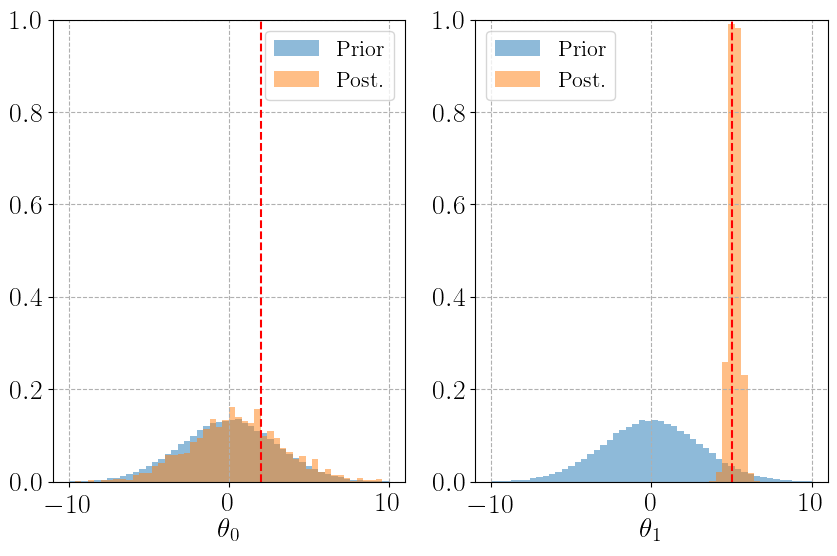

In [377]:
# Plot Posterior Distributions

fig = plt.figure(figsize=(10, 6))

param_range = [-10, 10]

BINS=50

ax = fig.add_subplot(121)
ax.hist(prior[:,0], bins=BINS, density=True, range=param_range, facecolor=cycle[0], alpha=.5, label='Prior')
ax.hist(post_samples_1[:,0], bins=BINS, density=True, range=param_range, facecolor=cycle[1], alpha=.5, label='Post.')
ax.axvline(theta_true[0][-2], ls='--', c='r')
ax.grid(True, ls='--')
ax.set_xlabel(r'$\theta_0$', size=20)
ax.tick_params(labelsize=20)
ax.legend()
ax.set_ylim([0, 1])

ax = fig.add_subplot(122)
ax.hist(prior[:,1], bins=BINS, density=True, range=param_range, facecolor=cycle[0], alpha=.5, label='Prior')
ax.hist(post_samples_1[:,1], bins=BINS, density=True, range=param_range, facecolor=cycle[1], alpha=.5, label='Post.')
ax.axvline(theta_true[0][-1], ls='--', c='r')
ax.grid(True, ls='--')
ax.set_xlabel(r'$\theta_1$', size=20)
ax.tick_params(labelsize=20)
ax.legend()
ax.set_ylim([0, 1]);

## Plot Posterior Predictive

In [385]:
bounds = [-10, 10]

design_space = np.linspace(-10, 10, 100)

# Convert to PyTorch Tensors; put on CPU/GPU
X = torch.tensor(prior, dtype=torch.float, device=device, requires_grad=False)

data_prior = list()
for d_space in tqdm(design_space):
    
    d = torch.tensor(d_space.reshape(-1, 1), dtype=torch.float, device=device, requires_grad=True)
    d.to(device)

    y, _ = sim_linear_torch(d, X, device)
    data_prior.append(y.data.tolist())
data_prior = np.array(data_prior)

100%|██████████| 100/100 [00:04<00:00, 24.51it/s]


In [386]:
bounds = [-10, 10]

design_space = np.linspace(-10, 10, 100)

# Convert to PyTorch Tensors; put on CPU/GPU
X = torch.tensor(post_samples_1, dtype=torch.float, device=device, requires_grad=False)

data_post = list()
for d_space in tqdm(design_space):
    
    d = torch.tensor(d_space.reshape(-1, 1), dtype=torch.float, device=device, requires_grad=True)
    d.to(device)

    y, _ = sim_linear_torch(d, X, device)
    data_post.append(y.data.tolist())
data_post = np.array(data_post)

100%|██████████| 100/100 [00:04<00:00, 23.93it/s]


In [392]:
mean_data_1 = np.mean(data_prior, axis=1).reshape(-1)
std_data_1 = np.std(data_prior, axis=1).reshape(-1)

mean_data_1_post = np.mean(data_post, axis=1).reshape(-1)
std_data_1_post = np.std(data_post, axis=1).reshape(-1)

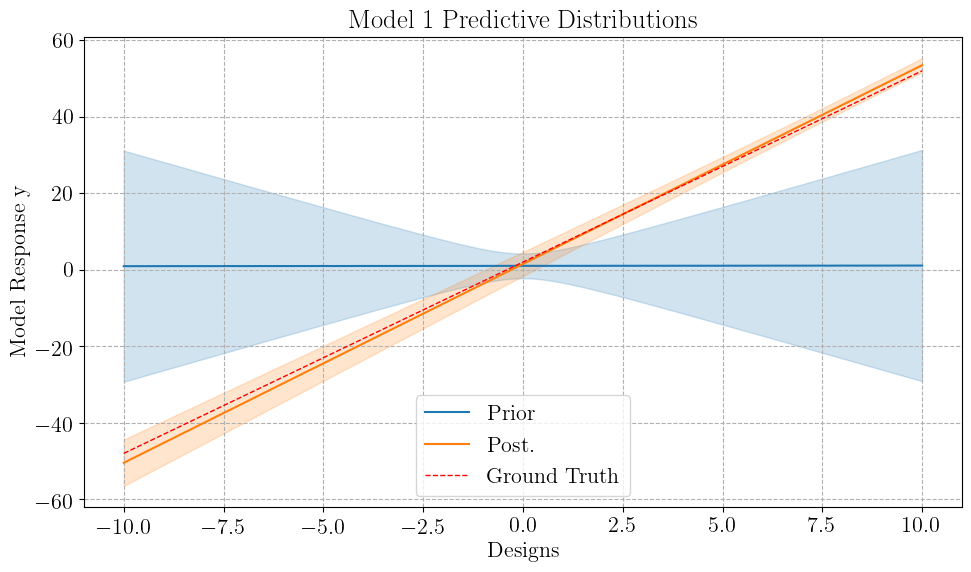

In [394]:
fig = plt.figure(figsize=(10, 6))

# MODEL 1

ax = fig.add_subplot(111)

ax.plot(design_space, mean_data_1, c=cycle[0], label='Prior')
ax.fill_between(design_space, mean_data_1 - std_data_1, mean_data_1 + std_data_1, color=cycle[0], alpha=0.2)
ax.plot(design_space, mean_data_1_post, c=cycle[1], label='Post.')
ax.fill_between(design_space, mean_data_1_post - std_data_1_post, mean_data_1_post + std_data_1_post, color=cycle[1], alpha=0.2)
xx = np.linspace(-10, 10, 1000)
ax.plot(xx, 2 + 5*xx, ls='--', c='r', lw=1, label='Ground Truth')

ax.set_xlabel('Designs')
ax.set_ylabel('Model Response y')
ax.set_title('Model 1 Predictive Distributions')
ax.legend(loc='lower center')
ax.grid(True, ls='--')

plt.tight_layout()